# Drug Overdose Analysis in Pennsylvania (01/2018-01/2020)
An exploration and analysis of an openly available overdose dataset from Open Data Pennsylvania. Includes data cleaning, EDA, modeling and model interpretation through SHAP.

## Background and Research Questions

## Impact of opioids in Pennsylvania

In 2017, the state of Pennsylvania had a population of 12.79 Million and:
- Had an estimated loss in wages due to opioid use of $2.6 billion representing a loss of $81 million in state tax revenue
- 2 out of 100  people suffered from a drug use disorder and over 10,700 deaths are attributed to overdose cases
- Over 3,100 babies were born with Neonatal Abstinence Syndrome and over 3,200 children were removed from their home due to parental drug use 

## Enter opioid antagonist

Opioids can cause difficulty breathing, sedation, potentially resulting in death. Opioid antagonist bind to opioid receptors and can reverse and block the effects of other opioids.

Opioid antidotes such as Naloxone, also known as Narcan, are medications that reverses opioid effects. Naloxone acts in 2-5 minutes. If the person doesn’t wake in 5 minutes, subsequent doses should be given. 

## What we want to achieve?

Identified by the state of Pennsylvania as one of the worst public health crisis in a generation, the opioid epidemic has far reaching economic and personal effects.  Given a two-year data set on overdose cases and survival rates in the state, identify drug usage, overdose and survival rate trends in order to recognize survival factor significance and to support future research to improve overdose survival and resource support.  

## Research Questions: 
- Is this data set, in its current structure, adequate to develop a useful prediction model for drug overdose and survival rates. 
- Identify interaction with drugs and geographic areas and potential local/community specific efforts underlying the data (identified by significantly higher survival rates).
- What factors are effective in increasing overdose survival rate odds.



In [1]:
# general imports
import pandas as pd
import numpy as np
import re

# web scraping
import requests
from bs4 import BeautifulSoup 

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling and interpretation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE, accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import shap

## Full dataset import and description

The dataset comes from Open Data Pennsylvania, the Commonwealth of Pennsylvania's public agency data portal. 

The dataset contains summary information on overdose responses and naloxone administrations by Pennsylvania criminal justice agencies and some third-party (i.e. EMS, Fire, Medical Staff, etc) first responders from January 2018 – January 2020 


In [3]:
# CSV file access through the data.pa.gov API
url = 'https://data.pa.gov/api/views/hbkk-dwy3/rows.csv?accessType=DOWNLOAD'

# Reading the file as a pandas dataframe
df = pd.read_csv(url, na_values='NA')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603 entries, 0 to 16602
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Incident ID                             16603 non-null  int64  
 1   Incident Date                           16603 non-null  object 
 2   Incident Time                           16603 non-null  object 
 3   Day                                     16603 non-null  object 
 4   Incident County Name                    16603 non-null  object 
 5   Incident State                          16603 non-null  object 
 6   Victim ID                               16603 non-null  int64  
 7   Gender Desc                             16603 non-null  object 
 8   Age Range                               16603 non-null  object 
 9   Race                                    16603 non-null  object 
 10  Ethnicity Desc                          16603 non-null  ob

In [4]:
df.shape

(16603, 34)

In [5]:
df.dtypes

Incident ID                                 int64
Incident Date                              object
Incident Time                              object
Day                                        object
Incident County Name                       object
Incident State                             object
Victim ID                                   int64
Gender Desc                                object
Age Range                                  object
Race                                       object
Ethnicity Desc                             object
Victim State                               object
Victim County                              object
Accidental Exposure                        object
Victim OD Drug ID                           int64
Susp OD Drug Desc                          object
Naloxone Administered                      object
Administration ID                           int64
Dose Count                                  int64
Dose Unit                                   int64


In [6]:
# Object features
df.select_dtypes('object').head()

Incident Date Incident Time       Day Incident County Name Incident State  \
0    01/04/2018      00:42:00  Thursday             Delaware   Pennsylvania   
1    01/04/2018      00:42:00  Thursday             Delaware   Pennsylvania   
2    01/04/2018      00:42:00  Thursday             Delaware   Pennsylvania   
3    01/04/2018      00:42:00  Thursday             Delaware   Pennsylvania   
4    01/26/2018      09:14:00    Friday              Chester   Pennsylvania   

  Gender Desc Age Range   Race Ethnicity Desc  Victim State  ...  \
0        Male   50 - 59  White   Not Hispanic  Pennsylvania  ...   
1        Male   50 - 59  White   Not Hispanic  Pennsylvania  ...   
2        Male   50 - 59  White   Not Hispanic  Pennsylvania  ...   
3        Male   50 - 59  White   Not Hispanic  Pennsylvania  ...   
4        Male   25 - 29  White   Not Hispanic  Pennsylvania  ...   

  Susp OD Drug Desc Naloxone Administered Dose Desc Response Time Desc  \
0     COCAINE/CRACK                     Y   UNKNOWN                NaN   
1     COCAINE/CRACK                     Y        MG                NaN   
2            HEROIN                     Y   UNKNOWN                NaN   
3            HEROIN                     Y        MG                NaN   
4            HEROIN                     N       NaN                NaN   

  Survive            Response Desc Revive Action Desc Third Party Admin Desc  \
0       N  NO RESPONSE TO NALOXONE                NaN         GOOD SAMARITAN   
1       N  NO RESPONSE TO NALOXONE                NaN                    NaN   
2       N  NO RESPONSE TO NALOXONE                NaN         GOOD SAMARITAN   
3       N  NO RESPONSE TO NALOXONE                NaN                    NaN   
4       N                      NaN                NaN                    NaN   

  Incident County Latitude and Longitude Victim County Latitude and Longitude  
0                (39.916579, -75.406277)              (39.916579, -75.406277)  
1                (39.916579, -75.406277)              (39.916579, -75.406277)  
2                (39.916579, -75.406277)              (39.916579, -75.406277)  
3                (39.916579, -75.406277)              (39.916579, -75.406277)  
4                (39.974871, -75.756265)              (39.974871, -75.756265)  

[5 rows x 22 columns]

In [7]:
# Numeric features
df.select_dtypes('number').head()

Incident ID  Victim ID  Victim OD Drug ID  Administration ID  Dose Count  \
0            1          1                  1                  1           1   
1            1          1                  1                  2           1   
2            1          1                  2                  1           1   
3            1          1                  2                  2           1   
4           26          5                  8                  0           0   

   Dose Unit  Incident County FIPS Code  Incident County Latitude  \
0          0                         45                 39.916579   
1          4                         45                 39.916579   
2          0                         45                 39.916579   
3          4                         45                 39.916579   
4          0                         29                 39.974871   

   Incident County Longitude  Victim County FIPS Code  Victim County Latitude  \
0                 -75.406277                     45.0               39.916579   
1                 -75.406277                     45.0               39.916579   
2                 -75.406277                     45.0               39.916579   
3                 -75.406277                     45.0               39.916579   
4                 -75.756265                     29.0               39.974871   

   Victim County Longitude  
0               -75.406277  
1               -75.406277  
2               -75.406277  
3               -75.406277  
4               -75.756265

In [74]:
# Percent missing
df.isna().sum()/len(df) * 100

incident_month         0.0
incident_qtr           0.0
incident_time_block    0.0
gender                 0.0
age_range              0.0
race                   0.0
susp_od_drug           0.0
dose_count             0.0
dose_unit              0.0
survive                0.0
county_latitude        0.0
county_longitude       0.0
weekend                0.0
high_pop               0.0
dtype: float64

## Initial Data Cleaning

In [6]:
# Formatting column names by lowercasing everything, replacing spaces with underscores and removing redundant words

df.columns = [x.lower().replace(" ","_").replace("_desc","").replace("incident_","") for x in df.columns]

In [11]:
# Columns that won't be used in analysis or visualizations

pointless_columns = [
    'id', 'state', 'victim_id', 'victim_od_drug_id',
    'victim_state', 'victim_county', 'victim_county_fips_code',
    'victim_county_latitude', 'victim_county_longitude', 'revive_action',
    'county_latitude_and_longitude', 'victim_county_latitude_and_longitude',
    'county_fips_code', 'dose', 'administration_id', 'ethnicity', 
    'response_time', 'response', 'third_party_admin', 'accidental_exposure'
]

In [12]:
df.drop(pointless_columns, axis=1, inplace=True)
df.drop(rows_to_drop, inplace=True)

In [7]:
# Removing missing drugs, missing survival labels and missing details about dose sizes.

missing_drugs = df[(df.susp_od_drug == 'UNKNOWN') | (df.susp_od_drug == 'OTHER')].index.to_list()
missing_survival_label = df[df.survive == 'U'].index.to_list()
missing_dose_details = df[(df.dose_count > 0) & (pd.isnull(df.dose_unit))].index.to_list()

# Both gender and race are missing (otherwise can be imputed)

unimputable_demographic =  df[((df.gender == 'Unknown') & (df.race == 'Unknown'))].index.to_list()

rows_to_drop = list(set(missing_drugs + missing_survival_label + unimputable_demographic + missing_dose_details))

In [13]:
def correct_capitalization(df, series):
    
    """
        Returns the correctly capitalized string for a DataFrame column for ease of reading.
        
    Parameters:
        df (pd.DataFrame): the pandas dataframe where the column is.
        param2 (str): the column name.

    Returns:
        pd.Series with correct capitalization.
        
    """
    return df.apply(lambda x: x[series].title(), axis=1)

In [14]:
df.susp_od_drug  = correct_capitalization(df, 'susp_od_drug')

In [15]:
# Replacing known NAs with appropriate values and remaining Unknowns with NAs
df.dose_count.fillna(0, inplace=True)
df.dose_unit.fillna(0, inplace=True)
df.replace('UNKNOWN', np.NaN, inplace=True)
df.replace('Unknown', np.NaN, inplace=True)

In [16]:
df.columns

Index(['date', 'time', 'day', 'county_name', 'gender', 'age_range', 'race',
       'susp_od_drug', 'naloxone_administered', 'dose_count', 'dose_unit',
       'survive', 'county_latitude', 'county_longitude'],
      dtype='object')

## Scraping county population

We are interested in knowing whether the naloxone effects might be attributable to the county population size, as with increased population there is an increase in services offered.

In [17]:
url='https://www.pennsylvania-demographics.com/counties_by_population'

# Create a handle, page, to handle the contents of the website
page = requests.get(url)

# Parse HTML
soup = BeautifulSoup(page.content, 'html.parser')

In [18]:
# Finding all table tags, table row tags and table data tags
tb = soup.find('table', class_='ranklist')
tr = tb.find_all("tr")
td = tb.find_all('td')

In [19]:
# Get every 3rd values from the table
county = td[1::3]
population = td[2::3]

In [20]:
# Clean the data
county = [x.text.strip().replace(' County', "") for x in county]
population = [int(x.text.strip().replace(",", "")) for x in population]

# Ensure the two lists are of the same length
assert len(county) == len(population)

In [21]:
pop = pd.DataFrame({'county': county, 'population': population})

# Set as 1 if population size is in the top quartile
pop['high_pop'] = pop.apply(lambda x: 1 if x.population >= pop.population.quantile(.75) else 0, axis=1)

In [22]:
pop

county  population  high_pop
0   Philadelphia     1575522         1
1      Allegheny     1225561         1
2     Montgomery      821301         1
3          Bucks      626370         1
4       Delaware      563527         1
..           ...         ...       ...
62        Potter       16937         0
63        Fulton       14506         0
64        Forest        7351         0
65      Sullivan        6177         0
66       Cameron        4686         0

[67 rows x 3 columns]

## Feature Engineering

In [23]:
df.date = pd.to_datetime(df.date)
df.time = pd.to_datetime(df.time, format='%H:%M:%S')

In [24]:
# Time blocks:
# 1 - 12:00AM - 5:59AM
# 2 - 6:00AM - 11:59AM
# 3 - 12:00PM - 5:59PM
# 4 - 6:00PM - 11:59PM
df.insert(0, 'incident_time_block', np.ceil(pd.DatetimeIndex(pd.to_datetime(df['time'])).hour/6).astype(int))
df['incident_time_block'] = df.apply(lambda x: 1 if x['incident_time_block'] == 0 else x['incident_time_block'], axis=1)

df.insert(0, 'incident_qtr', df.date.dt.quarter)
df.insert(0, 'incident_month', df.date.dt.month)
df.insert(0, 'incident_day', df.date.dt.day)

In [25]:
df['weekend'] = df.apply(lambda x: 1 if x.day in ('Friday', 'Saturday', 'Sunday') else 0, axis = 1)
df['high_pop'] = df.apply(lambda x: int(pop[pop.county == x.county_name].high_pop.values), axis=1)

In [26]:
df.survive = df.apply(lambda x: 1 if x.survive == "Y" else 0, axis = 1)
df.naloxone_administered = df.apply(lambda x: 1 if x.naloxone_administered == "Y" else 0, axis = 1)

In [27]:
# Remove everything in parenthesis from the drug name (too long and unnecessary)
df.susp_od_drug = df.apply(lambda x : re.sub(r'\([^)]*\)', '', x.susp_od_drug), axis=1)

In [28]:
df.shape

(13728, 20)

## Visualizations

In [29]:
# Set figure size for all the plots
plt.rcParams['figure.figsize'] = [20, 10]

### Age range distribution

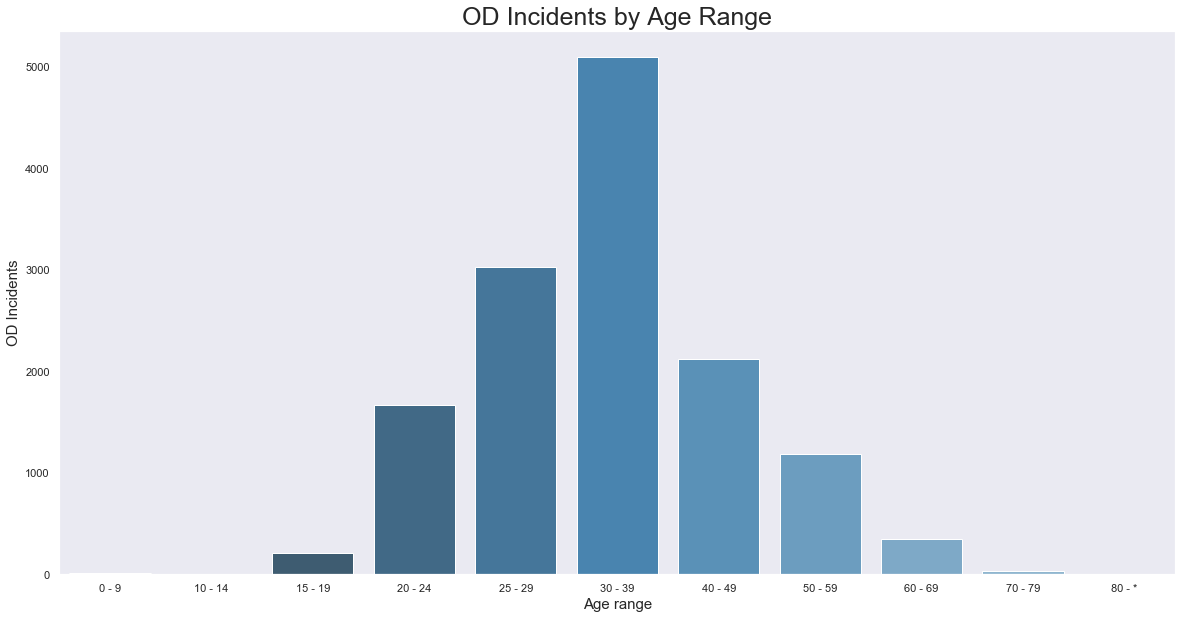

In [30]:
sns.set(style="dark")
sns.countplot( x = 'age_range', data = df.sort_values('age_range'), palette='Blues_d')
plt.xlabel("Age range", fontsize = 15)
plt.ylabel("OD Incidents", fontsize = 15)
plt.title("OD Incidents by Age Range", fontsize = 25)
plt.show()

Here, it is apparent that the overdose cases are relatively normally distributed across the age ranges with a slight right skew and with the highest frequency occurring in the middle, 30-39 range. 


### Overdose Density by County

In [31]:
tab_county = pd.crosstab(index=df['county_name'], columns="count") 
tab_county = pd.merge(left = pop, right = tab_county, how = 'left', left_on = 'county', right_on = 'county_name')
tab_county['drug_density'] = (tab_county['count']/tab_county['population'])*10000

In [32]:
dense_high = tab_county.nlargest(5,'drug_density')
dense_low = tab_county.nsmallest(5,'drug_density')
dense = dense_high.append(dense_low).sort_values(by=['drug_density'])

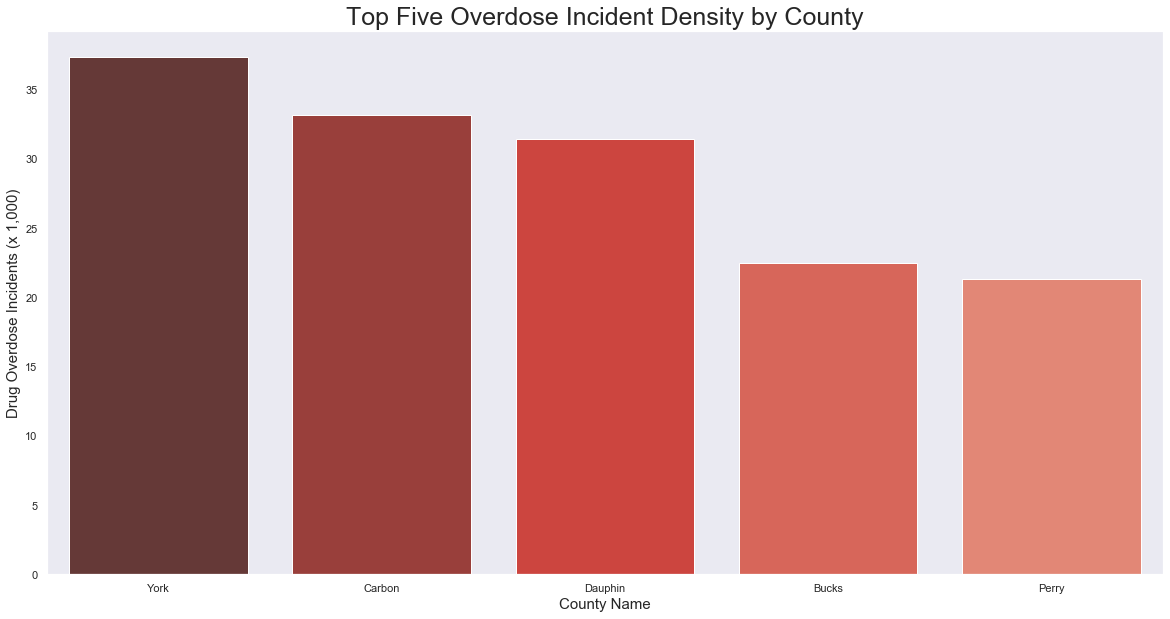

In [33]:
sns.set(style="dark")

# Plots the data on a bar chart and displays it
sns.barplot(x=dense_high['county'].values,
           y=dense_high['drug_density'].values,
           palette = 'Reds_d')

plt.xlabel("County Name", fontsize = 15)
plt.ylabel("Drug Overdose Incidents (x 1,000)", fontsize = 15)
plt.title("Top Five Overdose Incident Density by County", fontsize = 25)

plt.show()

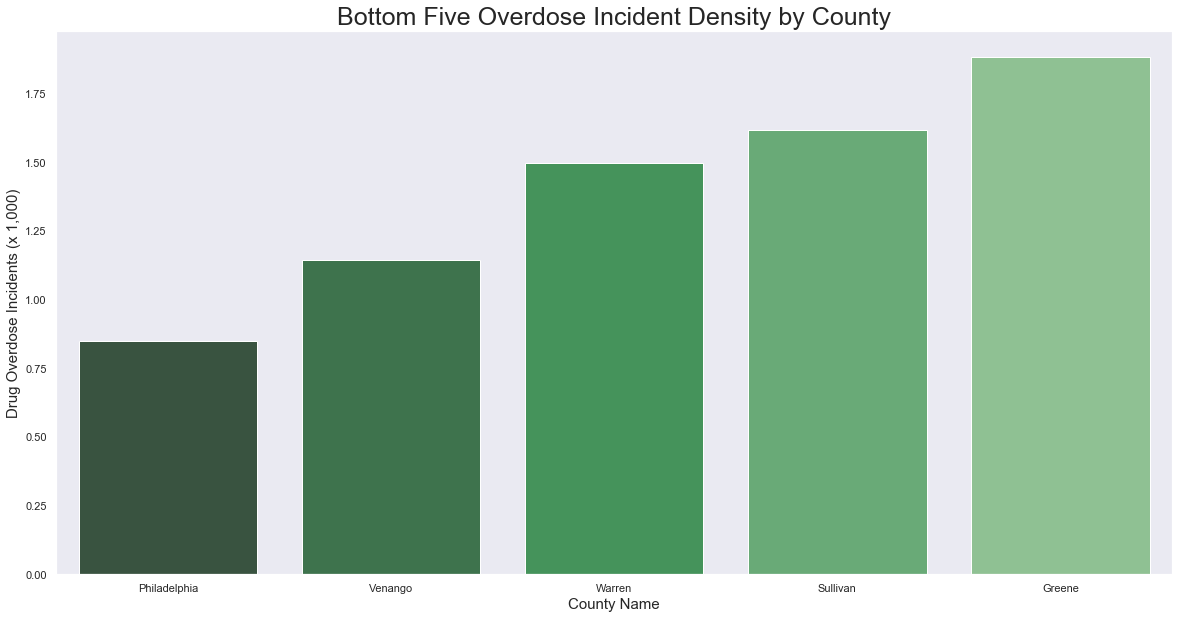

In [34]:
sns.set(style="dark")

# Plots the data on a bar chart and displays it
fig2 = sns.barplot(x=dense_low['county'].values, 
                 y=dense_low['drug_density'].values, palette = 'Greens_d') 

plt.xlabel("County Name", fontsize = 15)
plt.ylabel("Drug Overdose Incidents (x 1,000)", fontsize = 15)
plt.title("Bottom Five Overdose Incident Density by County", fontsize = 25)

plt.show()

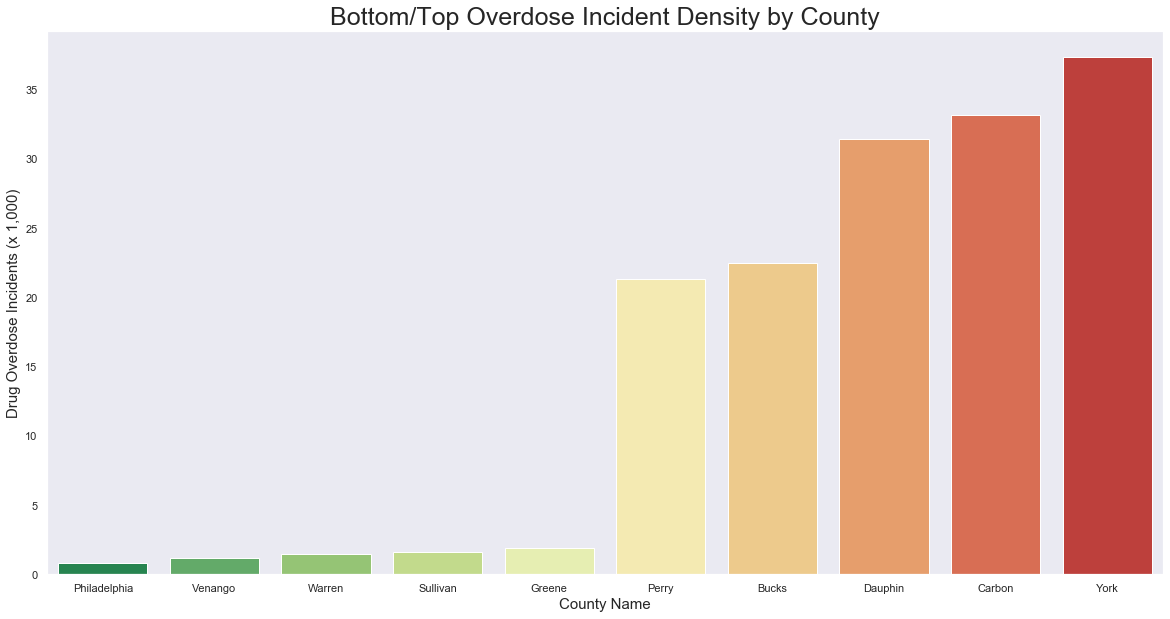

In [35]:
sns.set(style="dark")

# Plots the data on a bar chart and displays it
fig3 = sns.barplot(x=dense['county'].values, 
                 y=dense['drug_density'].values, palette = 'RdYlGn_r') 

plt.xlabel("County Name", fontsize = 15)
plt.ylabel("Drug Overdose Incidents (x 1,000)", fontsize = 15)
plt.title("Bottom/Top Overdose Incident Density by County", fontsize = 25)

plt.show()

Next, the overdose incident density is examined by adding county population data to the data set to compute overdose density in each county.  In the above chart, the bottom/top counties by incident density are compared. Though Philadelphia is the most populous county, it has one of the lowest absolute overdose incidents and overall lowest density. This may be an indication that this observation is an outlier and highlights some of the underlying issues within the dataset identified in the “Limitations” section. 


### Survival Rates by Gender and Drug and by County 

In [36]:
tab_survive = pd.pivot_table(df, index = 'county_name', values = 'survive', aggfunc='sum')      # Name the count column
tab_survive

survive
county_name          
Adams              75
Allegheny        1574
Armstrong          50
Beaver            119
Bedford            19
...               ...
Washington        166
Wayne              19
Westmoreland      267
Wyoming            19
York             1409

[67 rows x 1 columns]

<Figure size 1152x432 with 0 Axes>

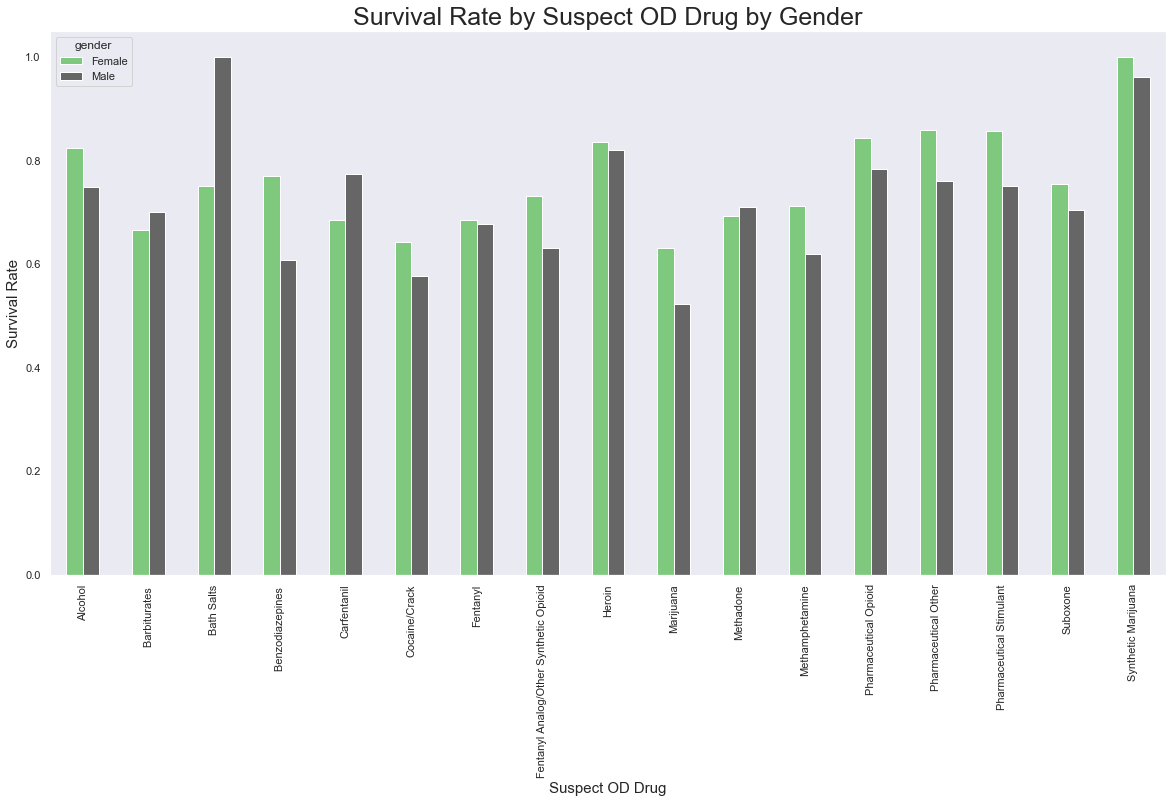

In [37]:
drug_survive = df.groupby(['susp_od_drug', 'gender']).mean().survive

sns.set(style="dark")
plt.figure(figsize=(16, 6))
drug_survive.unstack('gender').plot.bar(by='susp_od_drug', colormap='Accent')
plt.title("Survival Rate by Suspect OD Drug by Gender", fontsize = 25)
plt.xlabel('Suspect OD Drug', fontsize=15)
plt.ylabel('Survival Rate', fontsize=15)
plt.show()

The overall overdose survival rate was later found to be ~.67; here the trend in the data provides that female survival rate across almost all drug categories is higher than male. Further, some “deadliness” type factors emerge for particular drug types, highlighting their relative lethality. Some classes are slightly more suspicious, as they might have been the most apparent drug but not they key drug that led to the overdose (for example marijuana and alcohol).

In [38]:
county_count = pd.crosstab(index=df['county_name'], columns="count")
pop = pd.merge(left = pop, right = county_count, how = 'left', left_on = 'county', right_on = 'county_name')
pop = pd.merge(left = pop, right = tab_survive, how = 'left', left_on = 'county', right_on = 'county_name')
pop.head()

county  population  high_pop  count  survive
0  Philadelphia     1575522         1    134      124
1     Allegheny     1225561         1   1875     1574
2    Montgomery      821301         1    416      287
3         Bucks      626370         1   1407     1154
4      Delaware      563527         1    165      115

In [39]:
pop['survive_rate'] = (pop['survive']/pop['count'])
pop['drug_density'] = (pop['count']/pop['population'])*10000
pop.rename(columns = {'count':'overdoses'})
pop2 = pop.drop(['population', 'high_pop', 'drug_density', 'survive'], axis = 1)

In [41]:
# look at high and low survival rate counties. 
rate_sur_high = pop2.nlargest(5,'survive_rate')
rate_sur_low = pop2.nsmallest(5,'survive_rate')
rate_sur = rate_sur_high.append(rate_sur_low) 
rate_sur = rate_sur.sort_values(by=['survive_rate'])
rate_sur

county  count  survive_rate
60   Juniata     11      0.090909
56   Clarion     12      0.333333
50    McKean     13      0.461538
43     Wayne     38      0.500000
53    Snyder     24      0.500000
58       Elk     38      0.973684
62    Potter     13      1.000000
64    Forest      6      1.000000
65  Sullivan      1      1.000000
66   Cameron      1      1.000000

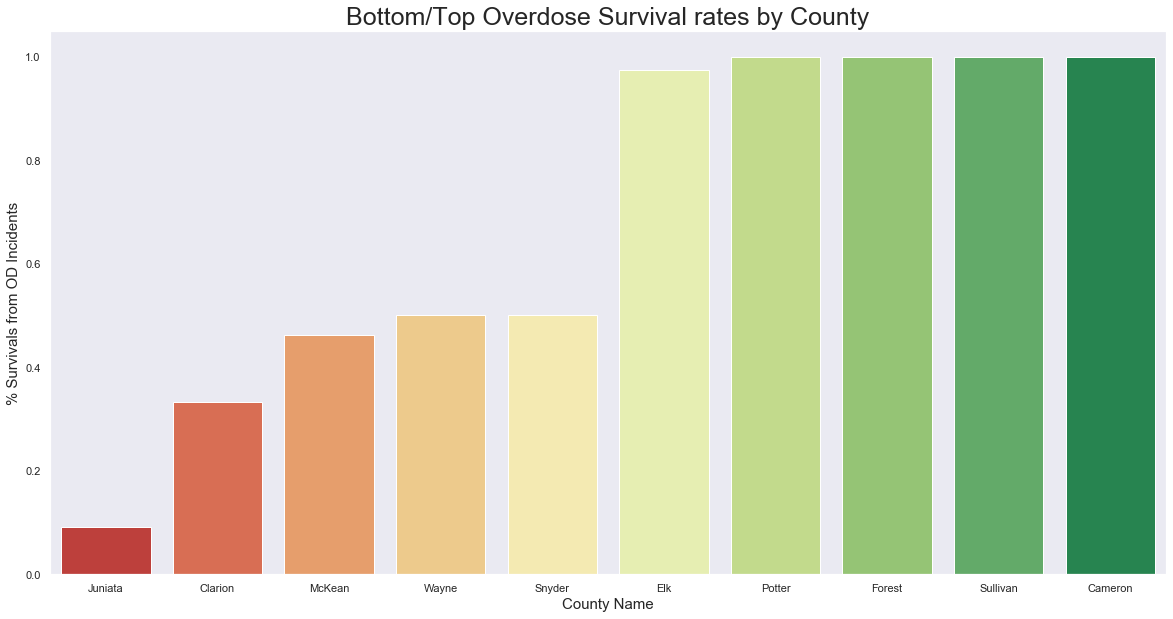

In [42]:
sns.set(style="dark")

# Plots the data on a bar chart and displays it
fig3 = sns.barplot(x=rate_sur['county'].values, 
                 y=rate_sur['survive_rate'].values, palette = 'RdYlGn') 
plt.xlabel("County Name", fontsize = 15)
plt.ylabel("% Survivals from OD Incidents", fontsize = 15)
plt.title("Bottom/Top Overdose Survival rates by County", fontsize = 25)
plt.show()

In a similar manner to overdose cases by county, overdose survival rates are determined and bottom/top counties compared.  While the previous graph is informative to the overall density of drug overdose cases, here survival rates may begin to support findings on factors leading to these higher/lower survival rates, such as access to better medical/emergency services. 


## Modeling

In [43]:
# Drop unnecessary/redundant variables
df.drop(['county_name', 'incident_day','date', 'time', 'day', 'naloxone_administered'], axis=1, inplace=True)

In [44]:
# Missing values remaining
df.isna().sum() * 100 / len(df)

incident_month         0.000000
incident_qtr           0.000000
incident_time_block    0.000000
gender                 0.203963
age_range              0.000000
race                   1.711830
susp_od_drug           0.000000
dose_count             0.000000
dose_unit              0.000000
survive                0.000000
county_latitude        0.000000
county_longitude       0.000000
weekend                0.000000
high_pop               0.000000
dtype: float64

In [45]:
# Fill missing values with mode (both are categorical)
df.race.fillna(df.race.mode()[0], inplace=True)
df.gender.fillna(df.gender.mode()[0], inplace=True)

# Changing gender to binary
df['male'] = df.gender.apply(lambda x: 1 if x == 'Male' else 0)
df.drop('gender', axis=1, inplace=True)

In [46]:
# Resetting observation index 
df.reset_index(drop=True, inplace=True)

In [47]:
# Features and target
X = df.drop('survive', axis=1)
y = df.survive

In [48]:
# Obtain dummies for remaining categorical data
X = pd.get_dummies(X)
X.shape

(13728, 43)

In [49]:
# Using the columns where there was no administration as baseline for calculating the effects of the dummy variables
X = X[X.columns.drop(list(X.filter(regex='No Administration')))]

In [50]:
# 70/30 train test split, stratification on the target variable to account for the limited class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, stratify=y, random_state=42)

In [51]:
# Selecting parameters for Grid Search optimization
param_grid = {
    'max_depth': [2, 5],
    'class_weight': [{0 : 1.5, 1 : 1}, 'none'],
    'n_estimators': [50, 75, 100, 150],
    'oob_score': [True],
    'n_jobs': [-1]
}

In [52]:
# Initializing a random forest classifier and using it as estimator for our Grid Search
rf = RandomForestClassifier()
rf_gridsearch = GridSearchCV(estimator=rf,
                             param_grid=param_grid,
                             scoring='roc_auc_ovr_weighted',
                             cv=5,
                             n_jobs=-1)

In [53]:
# Fitting the classifier to the training set
rf_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [54]:
# Using the a weighted ROC-AUC score, the best score this model obtains is an 81.9%. 
rf_gridsearch.best_score_

0.8187689125119044

In [55]:
# With the following parameters
rf_gridsearch.best_params_

{'class_weight': {0: 1.5, 1: 1},
 'max_depth': 5,
 'n_estimators': 150,
 'n_jobs': -1,
 'oob_score': True}

In [56]:
# Calculating predictions and predicted probabilities for test and training set

y_pred = rf_gridsearch.predict(X_test)
y_pred_proba = rf_gridsearch.predict_proba(X_test)[:,1]

y_pred_train = rf_gridsearch.predict(X_train)
y_pred_proba_train = rf_gridsearch.predict_proba(X_train)[:,1]

In [58]:
# Different measures of model performance

# RMSE
is_rmse = MSE(y_train, y_pred_train) ** (1/2) # In-sample
oos_rmse = MSE(y_test, y_pred) ** (1/2) # Out-of-sample

# Accuracy
is_accuracy = accuracy_score(y_train, y_pred_train) # In-sample
oos_accuracy = accuracy_score(y_test, y_pred) # Out-of-sample

# ROC-AUC
is_auc = roc_auc_score(y_train, y_pred_proba_train) # In-sample
oos_auc = roc_auc_score(y_test, y_pred_proba) # Out-of-sample

In [61]:
# Showing the results as a pandas dataframe
pd.DataFrame({
    'In-Sample': [round(is_rmse, 2), round(is_accuracy * 100, 2), round(is_auc, 2)],
    'Out-of-Sample': [round(oos_rmse, 2), round(oos_accuracy * 100, 2), round(oos_auc, 2)],},
    index=['RMSE', 'Accuracy', 'ROC-AUC'])

In-Sample  Out-of-Sample
RMSE           0.42           0.43
Accuracy      82.49          81.86
ROC-AUC        0.83           0.82

We fit the model on the test sample and test for Bias-Variance levels by computing RMSE, Accuracy and ROC-AUC scores on both train (in-sample) and test (out-of-sample) sets. Due to the consistent result across test and train samples, we can conclude we have achieved a satisfying bias-variance tradeoff.


In [66]:
# Using a function made by Zach Guo to pretty print the confusion matrix (https://gist.github.com/zachguo/10296432)

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [70]:
print_cm(confusion_matrix(y_train, y_pred_train), ['Not survived','Survived'])

                 Not survived     Survived 
    Not survived        822.0       1311.0 
        Survived        372.0       7104.0 


In [71]:
print_cm(confusion_matrix(y_test, y_pred), ['Not survived','Survived'])

                 Not survived     Survived 
    Not survived        346.0        568.0 
        Survived        179.0       3026.0 


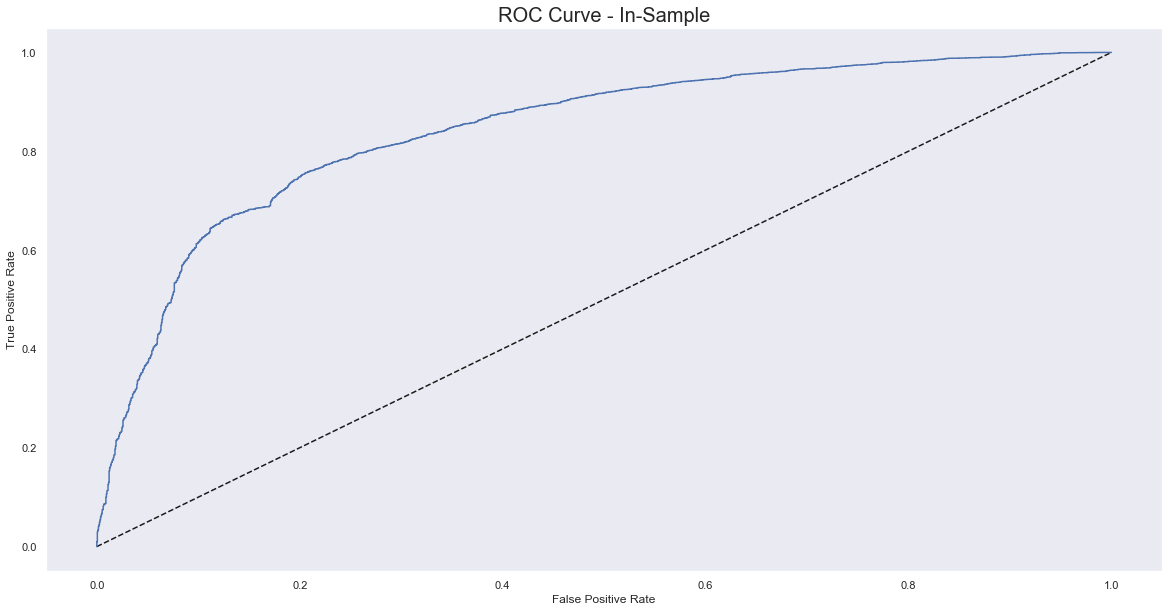

In [68]:
fpr, tpr, _ = roc_curve(y_train, y_pred_proba_train)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - In-Sample', fontsize=20)
plt.show()

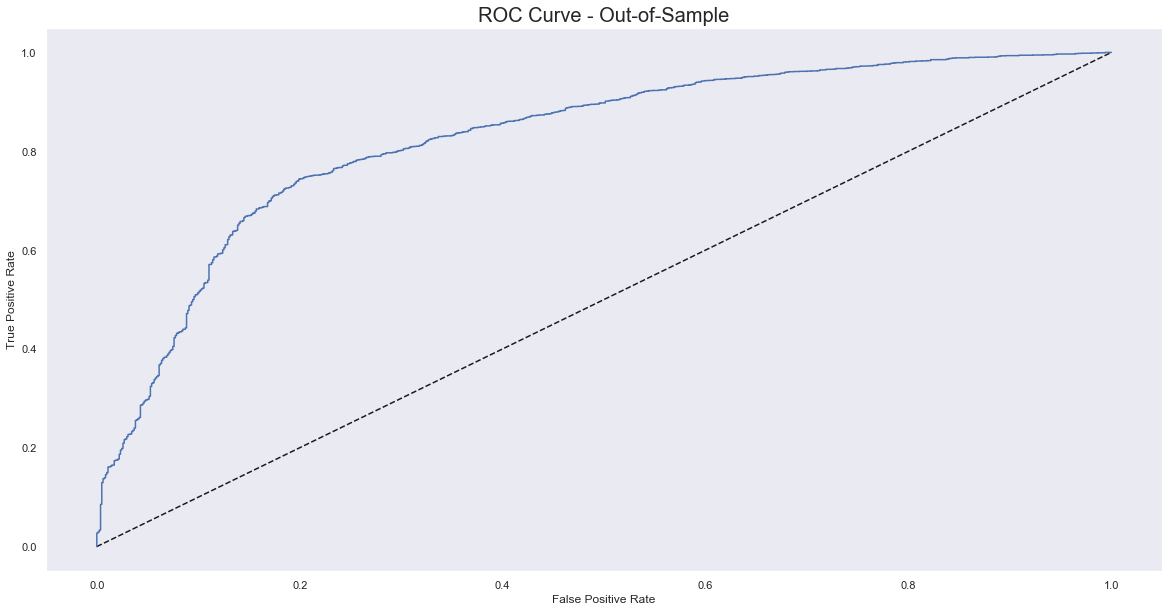

In [69]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Out-of-Sample', fontsize=20)
plt.show()

## Interpreting the model

A problem in machine learning algorithms is that we are unsure how the model obtains the results that it returned. This black-box approach is the reason why numerous applications of machine learning are controversial.

As an example, if a bank uses a machine learning algorithm to decide whether to offer a credit card to someone, they should also be able to explain why someone is rejected. Most notably, this happened to the (Apple-Goldman Sachs card)[https://www.wired.com/story/the-apple-card-didnt-see-genderand-thats-the-problem] recently and it has created a lot of buzz around the blind use of machine learning models.

A novel method for interpreting black-box model has been recently developed by Scott Lundberg and Su-In Lee and proposed in their paper “A Unified Approach to Interpreting Model Predictions”. This is the Shapley Additive Explanations (SHAP). We have implemented it in our model.

The base of SHAP is the Shapley value, a contribution metric used in Game Theory. SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value. This helps us, for example, in explaining not only that an observation had a probability X of survival, but that survival value was primarily due to features K, L and M.




In [72]:
import warnings
warnings.filterwarnings('ignore')

# Initialize JS environment for SHAP plot visualization.
shap.initjs()

In [73]:
# Extracting the best estimator from the Grid Search object
rf_gridsearch.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.5, 1: 1}, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=150, n_jobs=-1, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

In [74]:
# Fitting a shap explainer to our estimator and calculating the shap value
explainer = shap.TreeExplainer(rf_gridsearch.best_estimator_)
shap_values = explainer.shap_values(X_test)

In [75]:
# The expected (baseline) value for the observations
explainer.expected_value

array([0.33208409, 0.66791591])

In [76]:
# Fitting SHAP on the first observation for expected value of 1
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0])

In the output  we can see that we are looking for expected values of 1 (survival) and all the observations have a base probability of survival equal to 0.6679. 
This observation has a final survival probability of 0.82. This better probability was better than the base case due to having received 1 dose of 4 milligram Naloxone, as well as OD’ing on heroin instead of Fentanyl. We can also see that its probability was lowered by the age range of the victim and the incident time block (between 6:00AM and 12:00PM).

If we take all the bars for each observation, rotate them 90 degrees and put them all together, we obtain a SHAP force plot, which shows the primary factors that affected the outcomes. If we were to choose expected value of 0, we would obtain the same exact plot but flipped.

In [77]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)



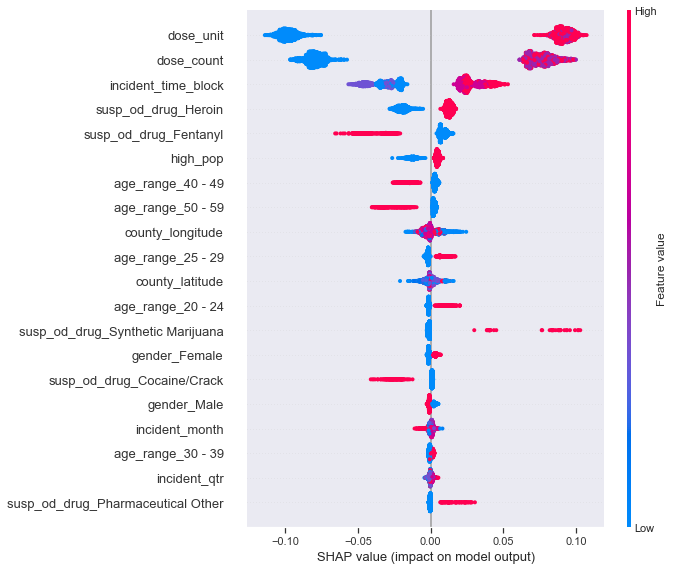

In [78]:
# Obtaining a Summary Plot from the SHAP values
shap.summary_plot(shap_values[1], X_test, plot_type="dot")

From a SHAP summary plot, we can understand what are the key factor that improve or reduce the survival odds. The plot shows a series of swarm plots, with each dot being the value for one specific feature of one specific observation. Blue colors indicate low feature values (for example 0 doses of naloxone), while magenta colors indicate high feature values (4 or 5 doses, for example). The X axis show the impact that the feature value has on the predicted probabilities of the model. 

From this dataset we can see that higher dose counts and dose unit sizes are very significant in improving the survival odds, while lower doses and sizes significantly reduce the odds. This leads us to believe that naloxone is a significant ally in the prevention of overdose deaths.

Among the drugs, fentanyl is the riskiest while heroin is more manageable. Age ranges between 40 and 59 are at higher risk while 20 to 29 are at lower risk. Finally, being in a high-population county improves the odds of survival, probably due to better access to emergency services or support.


## Conclusions and next steps

We have imported, cleaned and explored an extremely messy dataset from the State of Pennsylvania on overdose cases in the past two years and we have been able to gather insights on where the opioid crisis is hitting the Commonwealth more aggressively.

We identified trends in the overdoses, identifying riskier drugs, highly affected counties and other important features.
We created a machine learning model that is capable of predicting survival rate based on different attributes and we have been able to understand its predictive logic using a novel explanation methodology called SHAP.
With more targeted data and other important features, we can expand this model to encompass other Emergency Services cases and provide more insights on the important steps to take in limiting the opioid crisis in our State.


## Limitations

- Only 24 months of data. 

    - Challenging to conclude any findings for changes over time. 

- The drugs causing overdose are of unknown origin, composition and potency.

    - Survival rates and Naloxone effectiveness are therefore based on different underlying drugs

- Limited observation (patient) background data. 

    - Aside from age and ethnicity, demographic and medical background data not part of dataset. Effectiveness of Naloxone would require this additional information to improve model. 

- All data is only from Police/EMS department reports and may not be representative of entire PA drug, opioid and overdose cases.
    
    - There is also assumed to be a considerable amount of volunteer bias as well as inconsistencies with data collection given diversity of personnel (Police/EMS) inputting the data across the state. 


Sources:

https://www.wsj.com/articles/overdose-deaths-likely-to-fall-for-first-time-since-1990-11561541406

https://www.overdosefreepa.pitt.edu/know-the-facts/death-data-overview/

https://www.thenationaltriallawyers.org/2017/09/pennsylvania-county-sues-drug-companies-opioid-crisis/

https://data.pa.gov/stories/s/Pennsylvania-Opioids/9q45-nckt/

http://www.nchrc.org/programs-and-services/naloxone-101/

https://www.drugabuse.gov/related-topics/opioid-overdose-reversal-naloxone-narcan-evzio

https://harmreduction.org/wp-content/uploads/2012/02/naloxone-two.png
